In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
from scipy import stats

In [2]:
df = pd.read_parquet('OSEBX_data.parquet')
df['Date'] = pd.to_datetime(df['Date'])
df = df[['SecurityId','Date','Close']].pivot_table(columns='SecurityId', index='Date', values='Close')

df = df.dropna(how='all')  # Drop rows where all cells are NaN
df = df.dropna(how='all', axis=1)  # Drop columns where all cells are NaN

df

SecurityId,6000,6001,6002,6004,6005,6006,6007,6008,6009,6012,...,1304857,1305028,1305040,1305053,1305074,1305127,1305295,1305313,1305435,1305713
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,NaN,NaN,NaN,NaN,NaN,186.0,NaN,NaN,NaN,NaN,...,59.4,26.40,19.90,12.30,14.70,265.6,21.06,7.80,64.40,53.00
2020-11-24,NaN,NaN,NaN,NaN,NaN,178.0,NaN,NaN,NaN,NaN,...,59.6,27.10,21.20,12.35,15.10,268.0,22.42,9.20,61.42,52.00
2020-11-25,NaN,NaN,NaN,NaN,NaN,170.0,NaN,NaN,NaN,NaN,...,60.4,27.00,21.45,12.20,14.60,271.6,22.00,8.93,61.65,49.50


In [3]:
def find_co_integretables(df, p=0.05):
    significant_pairs = []

    # Get all combinations of time series
    for series1, series2 in combinations(df.columns, 2):
        series1_data = df[series1]
        series2_data = df[series2]
        
        # Calculate the differences between the two series
        difference = series1_data - series2_data
        
        # If the difference is a constant, skip this pair
        if difference.nunique() <= 1:
            continue

        try:
            # Run the adfuller test on the difference
            adf_result = adfuller(difference)
            # If the p-value is below the specified threshold, we consider the result statistically significant
            if adf_result[1] < p:
                significant_pairs.append((series1, series2))
        except ValueError:
            continue  # skip this pair if the ADF test raises a ValueError

    # Print pairs of series with statistically significant results
    for pair in significant_pairs:
        print(f"The pair {pair} has a statistically significant result.")
    if not significant_pairs:
        print('None found')
     
    return significant_pairs

In [4]:
len = 2000
end = 1500
co_int = find_co_integretables(df.iloc[-len:-end].dropna(axis=1), p=0.001)

The pair (45901, 59574) has a statistically significant result.
The pair (51529, 81451) has a statistically significant result.


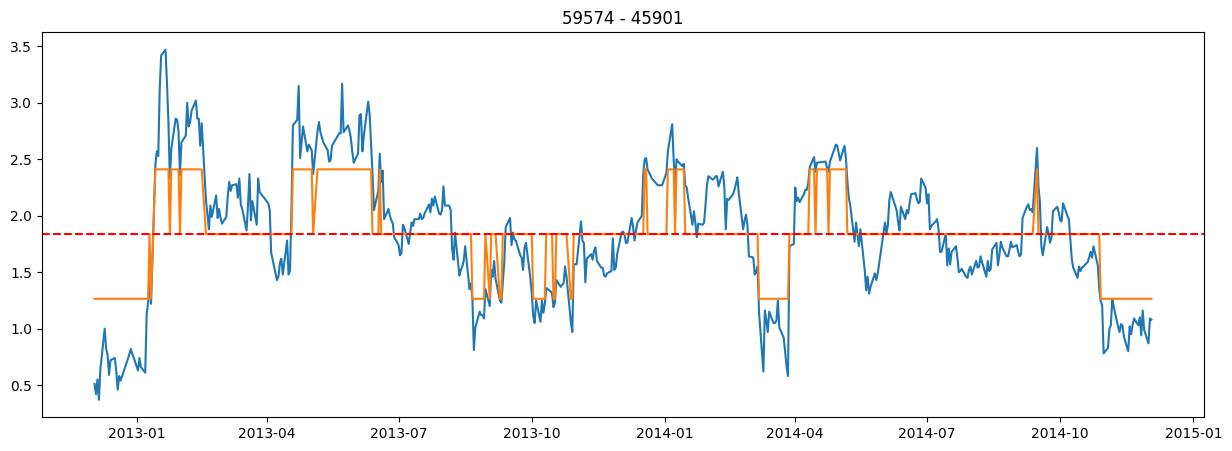

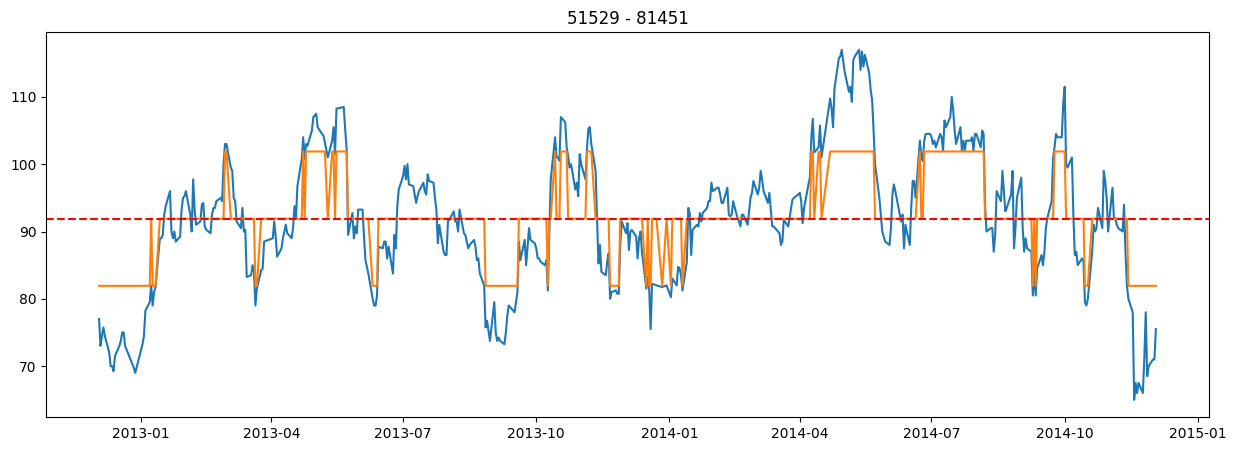

In [5]:
for i in co_int:
    x, y = i

    if (df[x]-df[y]).iloc[-len:-end].mean() < 0:
        x, y = y, x
        
    asset = (df[x] - df[y]).iloc[-len:-end]
    asset_mean = asset.iloc[:(len - end)].mean()
    asset_std = asset.iloc[:(len-end)].std()
    signal = np.where(asset>=asset_mean+asset_std,asset_mean+asset_std, np.where(asset<=asset_mean-asset_std,asset_mean-asset_std, asset_mean))
    plt.figure(figsize=(15,5))
    plt.plot(df.index[-len:-end],asset)
    plt.plot(df.index[-len:-end], signal)
    plt.axhline((asset_mean), c='r', linestyle='--')
    #plt.axvline(df.index[len], c='r', linestyle='--')
    plt.title(str(x) + ' - ' + str(y))
    plt.show()

In [ ]:
asset = (df[x] - df[y]).iloc[-len:-end]
asset_mean = stats.mode(asset, keepdims=False)[0]

In [16]:
def profit(asset, asset_mean, t1, t2):
    t1_signal = np.where(asset>=t1 + asset_mean, t1, np.where(asset<=asset_mean,0, np.nan))
    t2_signal = np.where(asset<= -t2 + asset_mean, t2, np.where(asset>=asset_mean,0, np.nan))
    
    t1_return = np.sum(np.diff(t1_signal[~np.isnan(t1_signal)])[np.diff(t1_signal[~np.isnan(t1_signal)])>0])
    t2_return = np.sum(np.diff(t2_signal[~np.isnan(t2_signal)])[np.diff(t2_signal[~np.isnan(t2_signal)])>0])
    return t1_return + t2_return

for i 
t1_results = []
for i in np.linspace(0,40,1000): # optimze t1
    x = profit(asset, asset_mean, i, 0)
    t1_results.append((i , x))
t1 = max(t1_results, key=lambda item: item[1])[0]

t2_results = []
for i in np.linspace(0,40,1000): # optimze t2
    x = profit(asset, asset_mean, t1, i)
    t2_results.append((i , x))
t2 = max(t2_results, key=lambda item: item[1])[0]

print((profit(asset, asset_mean, t1, t2))/asset_mean, t1, t2)

1.9334890446001556 5.965965965965966 8.72872872872873


# signal estimator drilldown

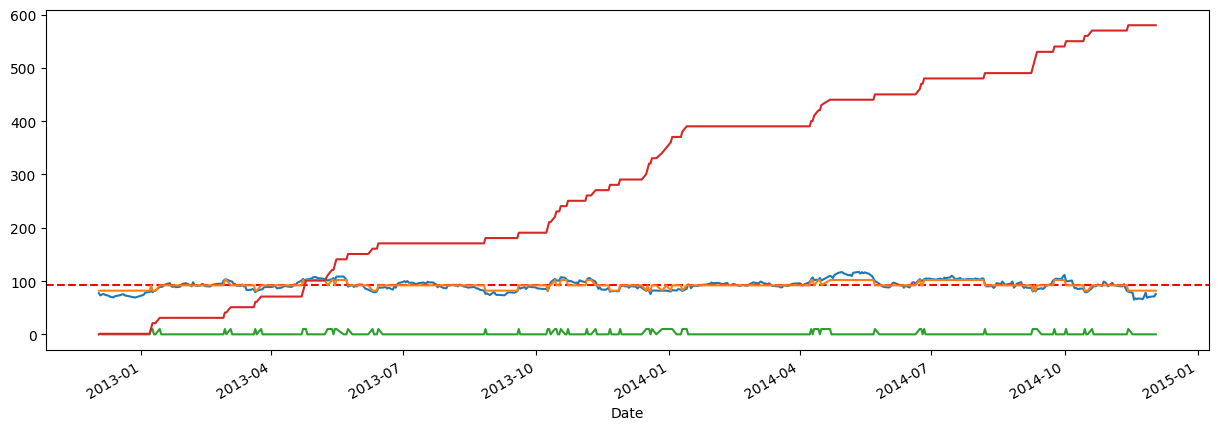

In [7]:
asset.plot(figsize=(15,5))
plt.axhline(asset.mean(), color='r', linestyle='--')
plt.plot(asset.index, signal)
plt.plot(asset.index, np.insert(np.abs(np.diff(signal)), 1,1))
plt.plot(asset.index, np.insert(np.abs(np.diff(signal)), 1,1).cumsum())
plt.show()

91.909
91.5
90.0


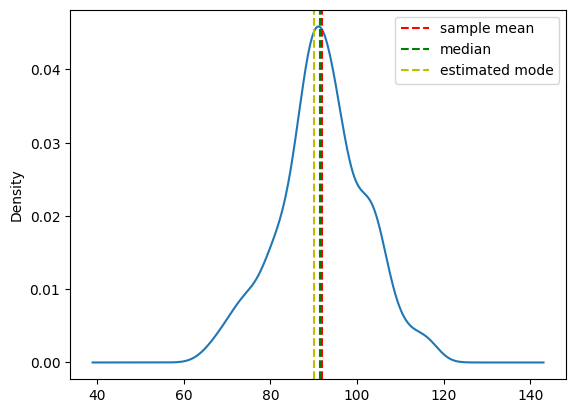

In [8]:
print(asset.mean())
print(asset.median())
print(stats.mode(asset, keepdims=False)[0])
asset.plot.kde()
plt.axvline(asset.mean(), linestyle='--', color='r', label='sample mean')
plt.axvline(asset.median(), linestyle='--', color='g', label='median')
plt.axvline(stats.mode(asset, keepdims=False)[0], linestyle='--', color='y', label='estimated mode')
plt.legend()
plt.show()

In [9]:
mu = stats.mode(asset, keepdims=False)[0]
t = 10
np.diff(np.where(asset >= mu + t, t, np.where(asset <= mu -  t, t, 0)))

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, -10,  10, -10,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  10,   0,   0, -10,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  10, -10,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, -10,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  10,   0,   0, -10,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10, -10,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  10,   0,   

In [10]:
np.sum(np.where(asset >= mu + t, t, np.where(asset <= mu -  t, t, 0)))

1710

In [11]:
def optimal_treshhold(asset, mu,t):
    return np.sum(np.where(asset >= mu + t, t, np.where(asset <= mu -  t, t, 0)))

In [12]:
mu = stats.mode(asset, keepdims=False)[0]
results = []
for i in np.linspace(0,20,1000):
    x = optimal_treshhold(asset, mu, i)
    results.append((i , x))

# print(results)

max(results, key=lambda item: item[1])

[(0.0, 0.0), (0.02002002002002002, 9.729729729729728), (0.04004004004004004, 19.459459459459456), (0.06006006006006006, 29.189189189189186), (0.08008008008008008, 38.91891891891891), (0.10010010010010009, 48.64864864864864), (0.12012012012012012, 58.37837837837837), (0.14014014014014015, 68.1081081081081), (0.16016016016016016, 77.83783783783782), (0.18018018018018017, 87.56756756756755), (0.20020020020020018, 97.29729729729728), (0.22022022022022023, 107.027027027027), (0.24024024024024024, 116.75675675675674), (0.2602602602602603, 123.6236236236236), (0.2802802802802803, 133.13313313313313), (0.3003003003003003, 142.6426426426426), (0.3203203203203203, 152.15215215215213), (0.34034034034034033, 161.66166166166164), (0.36036036036036034, 171.17117117117112), (0.38038038038038036, 180.68068068068067), (0.40040040040040037, 190.19019019019015), (0.42042042042042044, 199.69969969969966), (0.44044044044044045, 209.20920920920918), (0.46046046046046046, 218.7187187187187), (0.4804804804804

(9.98998998998999, 1708.2882882882884)